<a href="https://colab.research.google.com/github/i-moes/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Group 7

---



In [4]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/i-moes/TM10007_PROJECT.git

# Install packages
!pip install sklearn numpy matplotlib

In [0]:
# # General packages
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
 
# Metrics
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Section 1: Data loading and cleaning

In this section the data is loaded and preprocessed.

In [6]:
## Load Data

from brats.load_data import load_data
data = load_data()

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


## Clean Data

# Replace all zero values with NaN
data.replace(0, np.nan, inplace=True)
# Replace all zero division errors with NaN
data.replace('#DIV/0!', np.nan, inplace=True)
# Replace all inf values with NaN
data.replace(np.inf, np.nan, inplace=True)

# Remove column when >5% of values is NaN
data.dropna(axis = 1, thresh=0.95*len(data.index), inplace=True)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Extract labels from dataframe
labels = data['label']
# Drop column containing patient labels for imputation
data_imp = data.drop(columns=['label'])

# Impute for NaN values
imputor = KNNImputer(n_neighbors=5, weights='uniform')
# this will look for all columns where we have NaN value and replace the NaN value with specified test statistic
array_imp = imputor.fit_transform(data_imp)
data_imp[:] = array_imp

print(f'The number of samples: {len(data_imp.index)}')
print(f'The number of columns: {len(data_imp.columns)}')


The number of samples: 167
The number of columns: 725
The number of samples: 167
The number of columns: 457
The number of samples: 167
The number of columns: 456


## Section 2: Splitting Data in Train and Test Set

The data is splitted into a train and test set. This is done using train_test_split from sklearn.model_selection. The test data contains 45% of the data. 

In [7]:
# splitting data in train and test set 
x_train, x_test, y_train, y_test = train_test_split(data_imp, labels, test_size = 0.45)
print(x_train.head())
print(y_train.head())

              VOLUME_NET  VOLUME_ED  ...  TGM_Cog_Z_1  TGM_T_1
ID                                   ...                      
TCGA-HT-7680      9634.0     7323.0  ...     0.047688   38.485
TCGA-76-6664      2593.0   105764.0  ...     0.084347   68.903
TCGA-06-6389      4159.0    37895.0  ...     0.076467  117.720
TCGA-FG-6691     83603.0    33391.0  ...     0.081901  467.756
TCGA-DU-A5TU     65330.0    93210.0  ...     0.100155  195.791

[5 rows x 456 columns]
ID
TCGA-HT-7680    LGG
TCGA-76-6664    GBM
TCGA-06-6389    GBM
TCGA-FG-6691    LGG
TCGA-DU-A5TU    LGG
Name: label, dtype: object


## Section 3: Feature Extraction

Features are extracted from the train set with  ... 

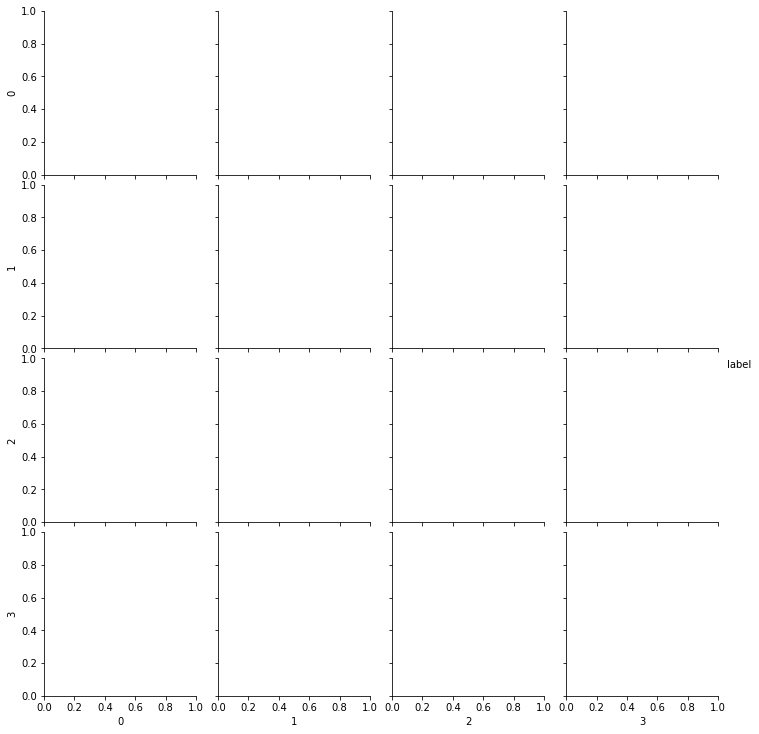

In [12]:
# Feature extraction
import sys
import os
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

def train_pca(point_data_train, point_data_test, components=4):
    '''
    The  Principal component analysis (PCA) training function creates
    and fits the PCA to transform point data into
    based on an amount of prinicipal components.
    Returns the transformed point data.

    Parameters
    ----------

    point_data_train : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.

    point_data_test : array-like, shape (n_samples, n_features)
        Testing data, where n_samples is the number of samples
        and n_features is the number of features.

    components : integer
        Amount of used principal components.
        Default value is 4 principal components

    Returns
    -------

    point_data_train_trans : array-like, shape (n_samples, n_features)
        Transformed training data, where n_samples is the number of samples
        and n_features is the number of features.

    point_data_test_trans : array-like, shape (n_samples, n_features)
        Transformed test data, where n_samples is the number of samples
        and n_features is the number of features.

    '''

    try:
        # Create a PCA which retains an amount of principle components
        pca = PCA(n_components=components)

        # Fit the PCA model
        pca.fit(point_data_train)

        # Transform data
        point_data_train_trans = pca.transform(point_data_train)
        point_data_test_trans = pca.transform(point_data_test)

        return point_data_train_trans, point_data_test_trans
    except ValueError:
        print('Not enough subjects per set to fit the requested amount of components in PCA.')
        sys.exit()

x_train_trans, x_test_trans = train_pca(x_train, x_test, components=4)

#print(x_train_trans)
#print(x_test_trans)

def pca4_plot(data, labels):
    '''
    Function to pairplot the results of the principal components analysis by creating
    a dataframe of the the data and labels. The plot is saved in the directory

    Parameters
    ----------
    data : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.

    labels : array, shape = [n_samples]
        Corresponding labels for data

    directory : string
        Defines where the results are saved as pdf

    '''

    # Creating a dataframe with the labels
    dataframe = pd.DataFrame(data)
    dataframe['label'] = labels

    # Plotting the pairplot and saving in directory as pdf
    pair_plot = sns.pairplot(dataframe, hue='label')
    
    
pca4_plot(x_train_trans, y_train)

## Section 4: Training Classifiers

In this section ... are trained on the train set using sklearn. 

In [0]:
# Classifiers

## Section 5: Performance Evaluation

Testing classifiers on test set. The following evaluation measures are evaluated:


*   Accuracy
*   F1-Score
*  AUC



In [0]:
# Metrics 